In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import heapq
import pickle
import os
import re
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

In [2]:
drive.mount('/content/gdrive', force_remount=True)

# Define function to load checkpoint
def load_checkpoint(model, save_dir, num_epochs, exact_checkpoint=None):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_files = [f for f in os.listdir(save_dir) if f.endswith('.pth')]
    training_finished = False

    if checkpoint_files:
        if "model_weights.pth" in checkpoint_files:
            latest_checkpoint_file = "model_weights.pth"
            training_finished = True
        elif exact_checkpoint is not None:
            latest_checkpoint_file = f"checkpoint_epoch_{exact_checkpoint}.pth"
        else:
            latest_checkpoint_file = max(checkpoint_files, key=lambda x: int(re.search(r'(\d+)', x).group()))
            print(f"Loading checkpoint: {latest_checkpoint_file}")

        model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))
        start_epoch = num_epochs if training_finished else int(re.search(r'(\d+)', latest_checkpoint_file).group()) + 1
    else:
        start_epoch = 0

    return start_epoch

Mounted at /content/gdrive


In [3]:
# Define ResNet34 Trainer
class ResNetTrainer:
    def __init__(self, epochs=20, batch_size=128, save_path="/content/gdrive/MyDrive/resnet34_cifar100"):
        self.epochs = epochs
        self.batch_size = batch_size
        self.save_path = save_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._prepare_data()
        self._build_model()

    def _prepare_data(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        self.trainloader = DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
        self.testloader = DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def _build_model(self):
        self.model = torchvision.models.resnet34(pretrained=False, num_classes=100).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def train(self):
        start_epoch = load_checkpoint(self.model, self.save_path, self.epochs)
        for epoch in range(start_epoch, self.epochs):
            self.model.train()
            running_loss = 0.0
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {running_loss / len(self.trainloader)}")
            checkpoint_path = os.path.join(self.save_path, f'checkpoint_epoch_{epoch + 1}.pth')
            torch.save(self.model.state_dict(), checkpoint_path)

    def load_model(self):
      if os.path.exists(self.save_path) and os.path.isdir(self.save_path):
          checkpoint_files = [f for f in os.listdir(self.save_path) if f.endswith('.pth')]
          if checkpoint_files:
              latest_checkpoint_file = max(checkpoint_files, key=lambda x: int(re.search(r'(\d+)', x).group()))
              checkpoint_path = os.path.join(self.save_path, latest_checkpoint_file)
              print(f"Loading model from {checkpoint_path}")
              self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
              self.model.eval()
          else:
              raise FileNotFoundError("No checkpoints found in the directory.")
      else:
          raise FileNotFoundError("Saved model directory not found.")

In [20]:
# Define Complexity Calculator
class ComplexityCalculator:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def compute_complexities(self):
        self.model.eval()
        all_confidences = []
        correct_predictions = []
        complexities = []
        confidences = []
        predictions = []
        all_images = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probabilities = torch.softmax(outputs, dim=1)
                conf, preds = torch.max(probabilities, dim=1)
                all_confidences.extend(conf.cpu().numpy())
                correct_predictions.extend((preds == labels).cpu().numpy())
                predictions.extend(preds.cpu().numpy())
                # true_labels.extend(labels.cpu().numpy())
                all_images.append(images.cpu())  # Move to CPU before storing
                all_labels.append(labels.cpu())

        # mean_confidence = sum(all_confidences) / len(all_confidences)
        # print("mean confidence is:"+ str(mean_confidence))
        test_images = torch.cat(all_images, dim=0)  # Concatenate into a single tensor
        test_labels = torch.cat(all_labels, dim=0)

        for conf, correct in zip(all_confidences, correct_predictions):
            if correct:
                complexity = 1 - (conf)
            else:
                complexity = 1 + conf
            complexities.append(complexity)
            confidences.append(conf)

        return complexities, confidences, predictions, test_images, test_labels

In [14]:
def find_images_by_complexity_and_correctness(complexities, images, labels, target_values, predictions, total_confidences, find_correct=True):
    complexities = np.array(complexities)
    selected_indices = []

    for target in target_values:
        # Sort indices by distance to target complexity
        sorted_indices = np.argsort(np.abs(complexities - target))

        found = False
        # Go through sorted indices until finding an image matching our correctness criteria
        for idx in sorted_indices:
            is_correct = (predictions[idx] == labels[idx])
            if is_correct == find_correct:
                selected_indices.append(idx)
                found = True
                break

        # If we couldn't find a matching image, take the closest one
        if not found:
            selected_indices.append(sorted_indices[0])
            print(f"Warning: Could not find {'correctly' if find_correct else 'incorrectly'} classified image near complexity {target}")

    return selected_indices

In [15]:
# Define Huffman Tree
class HuffmanNode:
    def __init__(self, value, complexity):
        self.value = value
        self.complexity = complexity
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.complexity < other.complexity

class HuffmanTree:
    def __init__(self, complexities):
        self.complexities = complexities
        self.root = self.build_tree()

    def build_tree(self):
        heap = [HuffmanNode(i, complexity) for i, complexity in enumerate(self.complexities)]
        heapq.heapify(heap)

        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            merged = HuffmanNode(None, left.complexity + right.complexity)
            merged.left = left
            merged.right = right
            heapq.heappush(heap, merged)

        return heap[0] if heap else None

    def get_codes(self):
      codes = {}
      stack = [(self.root, "")]

      while stack:
          node, code = stack.pop()
          if node:
              if node.value is not None:
                  codes[node.value] = code
              stack.append((node.right, code + "1"))
              stack.append((node.left, code + "0"))

      return codes

    def visualize_tree(self):
      """ Visualizes the Huffman Tree using an iterative BFS approach to prevent RecursionError """
      if not self.root:
          print("The Huffman Tree is empty.")
          return

      G = nx.DiGraph()
      pos = {}
      labels = {}

      queue = deque([(self.root, 0, 0, 1)])  # (node, x, y, dx)

      while queue:
          node, x, y, dx = queue.popleft()

          # Add node to the graph
          G.add_node(id(node))
          pos[id(node)] = (x, -y)
          labels[id(node)] = str(round(node.complexity, 2)) if node.value is None else f"V{node.value}"

          # Process left child
          if node.left:
              G.add_edge(id(node), id(node.left))
              queue.append((node.left, x - dx, y + 1, dx / 2))

          # Process right child
          if node.right:
              G.add_edge(id(node), id(node.right))
              queue.append((node.right, x + dx, y + 1, dx / 2))

      # Draw the graph
      plt.figure(figsize=(10, 6))
      nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color="lightblue", edge_color="gray", font_size=8)
      plt.title("Huffman Tree Visualization")
      plt.show()

In [31]:
def normalize_image(img):
    """Normalize image to [0, 1] range"""
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min) if img_max > img_min else img

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading checkpoint: checkpoint_epoch_20.pth
Loading model from /content/gdrive/MyDrive/resnet34_cifar100/checkpoint_epoch_20.pth


<ipython-input-2-c6343ed99c52>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))
<ipython-i

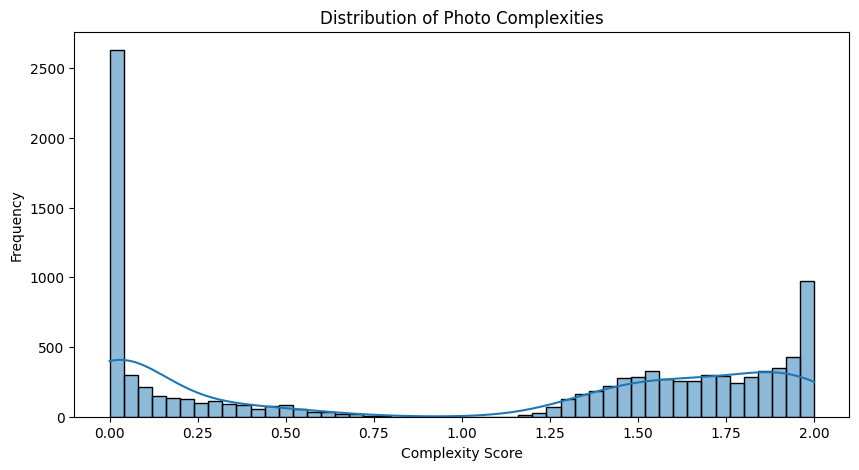

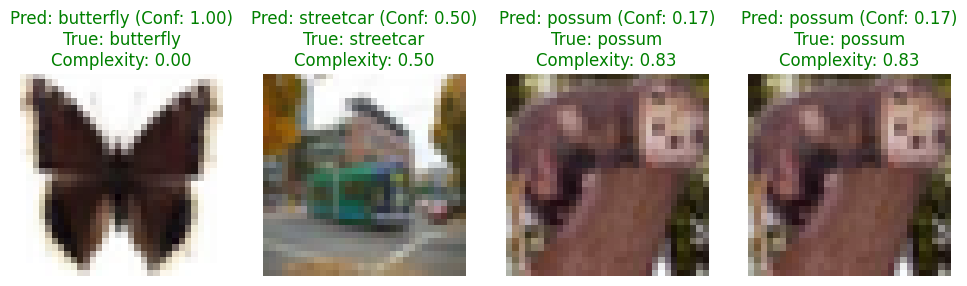

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Main execution
if __name__ == "__main__":
    trainer = ResNetTrainer()
    trainer.train()
    trainer.load_model()

    complexity_calculator = ComplexityCalculator(trainer.model, trainer.testloader, trainer.device)
    complexities, total_confidences, test_predictions, test_images, test_labels = complexity_calculator.compute_complexities()

    if isinstance(trainer.testloader.dataset.data, np.ndarray):
      test_images = test_images.numpy()  # Convert torch.Tensor -> NumPy array
      #print(1)
    if isinstance(trainer.testloader.dataset.targets, list):
      test_labels = test_labels.tolist()  # Convert torch.Tensor -> List
      #print(2)
    elif isinstance(trainer.testloader.dataset.targets, np.ndarray):
      test_labels = test_labels.numpy()
      #print(3)

    #print(test_images[0].dtype, test_labels[0])
    #print(trainer.testloader.dataset.data[0].dtype, trainer.testloader.dataset.targets[0])

    # Convert complexities to numpy array
    complexities = np.array(complexities)

    # Plot histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(complexities, bins=50, kde=True)
    plt.xlabel("Complexity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Photo Complexities")
    plt.show()

    # Extract test images and labels
    # test_images, test_labels = trainer.testloader.dataset.data, trainer.testloader.dataset.targets

    # Target complexities to find
    target_values = [0, 0.5, 1, 2]

    # CIFAR-100 class names
    class_names = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
        'worm'
    ]

    selected_indices = find_images_by_complexity_and_correctness(
    complexities, test_images, test_labels, target_values, test_predictions, total_confidences, find_correct=True
    )

    selected_images = [test_images[selected_indices[i]] for i in range(len(selected_indices))]
    selected_labels = [test_labels[selected_indices[i]] for i in range(len(selected_indices))]
    selected_complexities = [complexities[selected_indices[i]] for i in range(len(selected_indices))]
    selected_confidences = [total_confidences[selected_indices[i]] for i in range(len(selected_indices))]

    true_labels = selected_labels

    # Plot results
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    for i, ax in enumerate(axes):
        normalized_img = normalize_image(selected_images[i])
        ax.imshow(normalized_img.transpose(1, 2, 0))
        ax.axis('off')

        # This is the index in the original dataset
        idx = selected_indices[i]

        # Check correctness using the correct index
        correct = test_predictions[idx] == test_labels[idx]
        color = "green" if correct else "red"

        # Convert indices to class names using the correct index
        pred_label = class_names[test_predictions[idx]]
        true_label = class_names[true_labels[i]]  # Or test_labels[idx] directly

        # Display results with class names
        ax.set_title(f"Pred: {pred_label} (Conf: {selected_confidences[i]:.2f})\n"
                  f"True: {true_label}\n"
                  f"Complexity: {selected_complexities[i]:.2f}",
                  color=color)